In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import numpy as np 
import os 
import pandas as pd 
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict
import seaborn as sns
from pylab import rcParams
import math
import time
from tqdm import tqdm
import datetime 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings("ignore") 


np.random.seed(1234453)  
PYTHONHASHSEED = 0

In [2]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sisasoft-proje/term-deposit-marketing-2020.csv


Ultimately, at ACME we are looking to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.


In [3]:
df = pd.read_csv("/kaggle/input/sisasoft-proje/term-deposit-marketing-2020.csv")
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 40000 rows and 14 columns


In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [5]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

****Attributes:

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)

# Görselleştirme-EDA

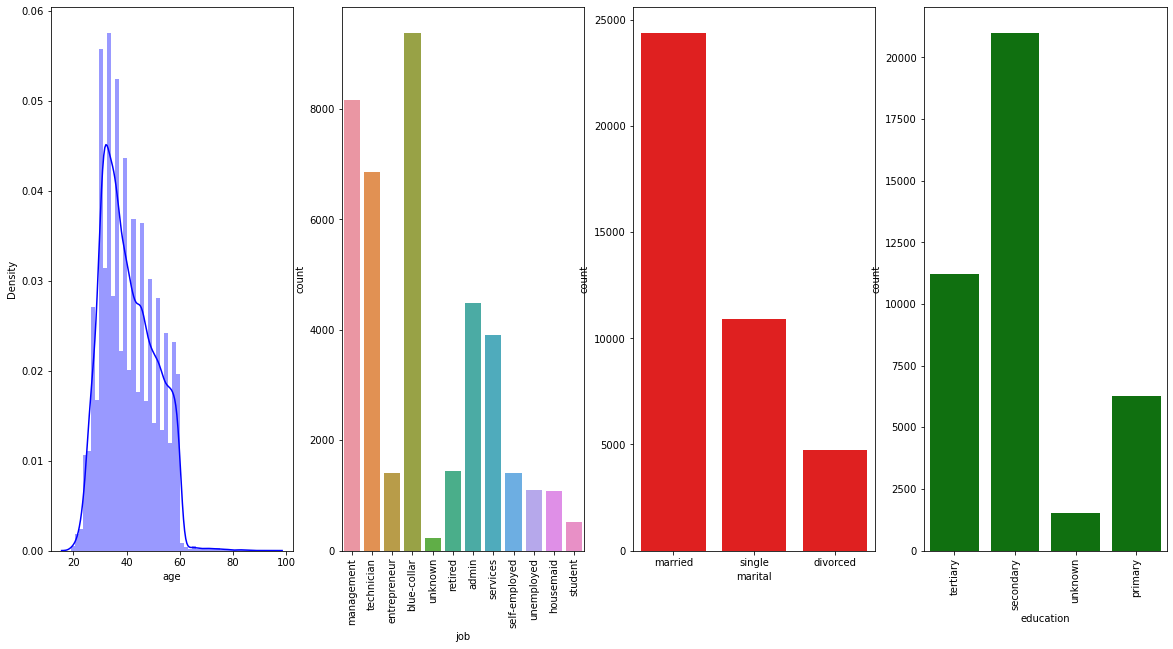

In [6]:
plt.figure(figsize=(20,10))

plt.subplot(1,4,1)
sns.distplot(df['age'],color='blue')

plt.subplot(1,4,2)
sns.countplot(df['job'])
plt.xticks(rotation=90)

plt.subplot(1,4,3)
sns.countplot(df['marital'], color='red')

plt.subplot(1,4,4)
sns.countplot(df['education'], color='green')
plt.xticks(rotation=90)

plt.show()

****
1. İlk grafiktede görüldüğü üzere datamızın çoğunluğunu 25-45 yaş arası insanlar oluşturuyor.
2. İkinci grafikte sektörlere göre datamızını çoğunluğunu blue-collar,management,technician,admin ve services oluşturuyor.
3. Üçüncü grafikte datamızın çoğunluğu evlilerden oluşuyor ondan sonra bekarlar, azınlığını boşanmışlar oluşturuyor.
4. Son grafiktede müşterilerimizin eğitim sıralaması secondary-tertiary-primary'den oluşuyor.

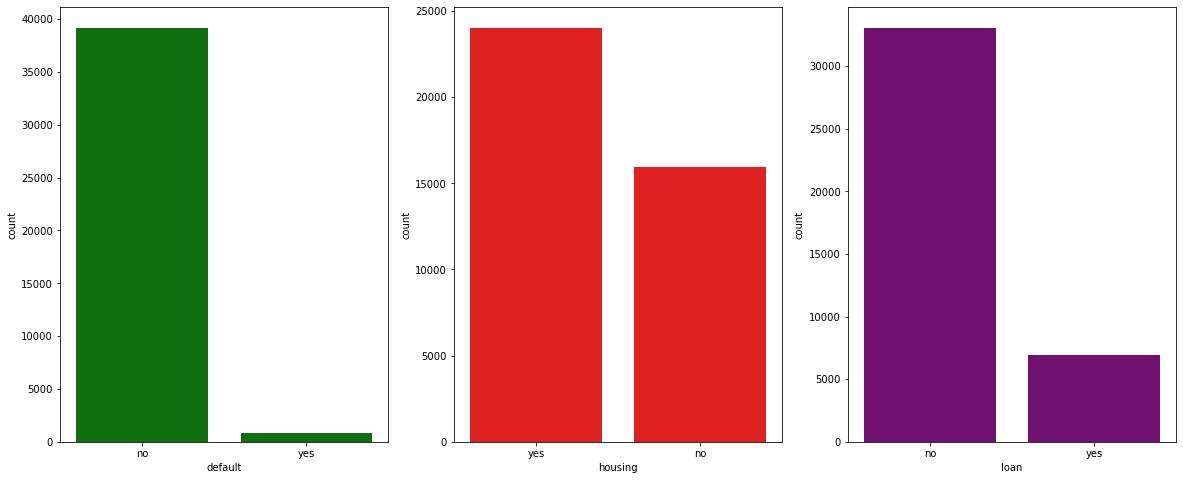

In [7]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.countplot(df['default'], color = 'green')

plt.subplot(1,3,2)
sns.countplot(df['housing'],  color = 'red')

plt.subplot(1,3,3)
sns.countplot(df['loan'],  color = 'purple')

plt.show()

1. İlk grafikten çoğunluğun haciz borcu olduğu görülüyor.
2. İkinci grafikten çoğunluğun ev borcu olduğu görülüyor.
3. Son grafikten bireysel kredi borcu olmayanların çoğunlukta olduğu görülüyor.

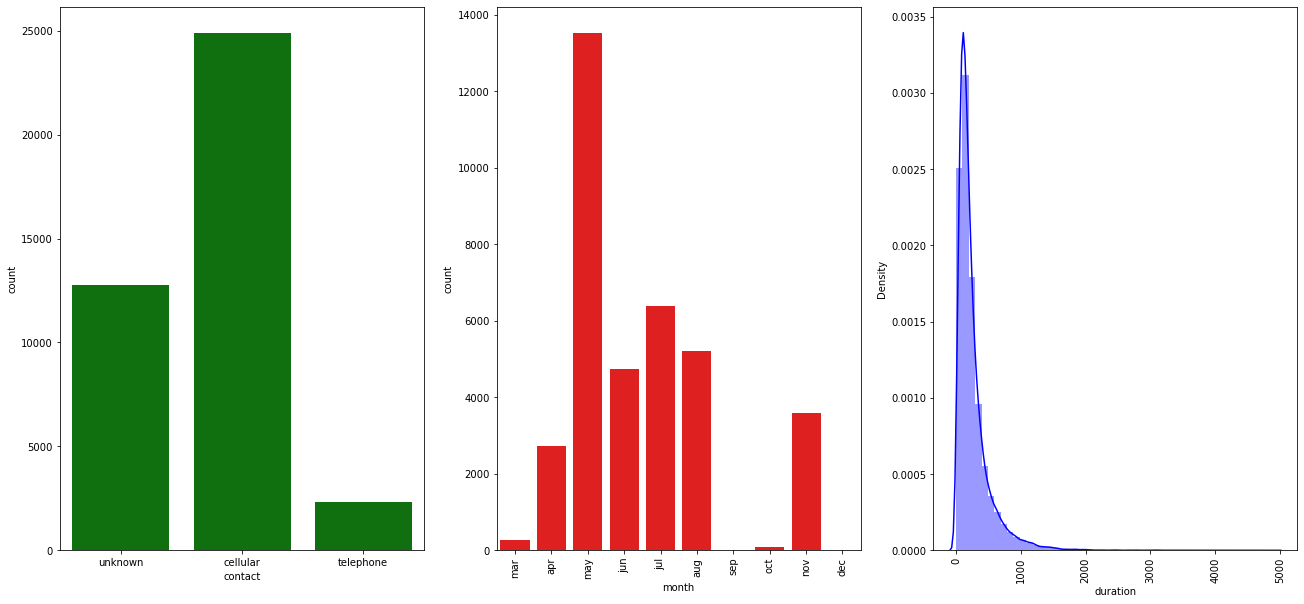

In [8]:
plt.figure(figsize=(30,10))

plt.subplot(1,4,1)
sns.countplot(df['contact'], color = 'green')

plt.subplot(1,4,2)
sns.countplot(df['month'], color='red',order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
plt.xticks(rotation=90)

plt.subplot(1,4,3)
sns.distplot(df['duration'], color = 'blue')
plt.xticks(rotation=90)

plt.show()

1. İlk grafikten müşterilerle çoğunlukla cep telefonu ile iletişime geçildiği görülüyor.
2. İkinci grafikten aramaların nisan ağutos arası yapıldığı anlaşılıyor.
3. Son grafikten de son görüşmelerin 0 ile 1000 sn arasında yapıldığı görülüyor.

<AxesSubplot:xlabel='campaign', ylabel='count'>

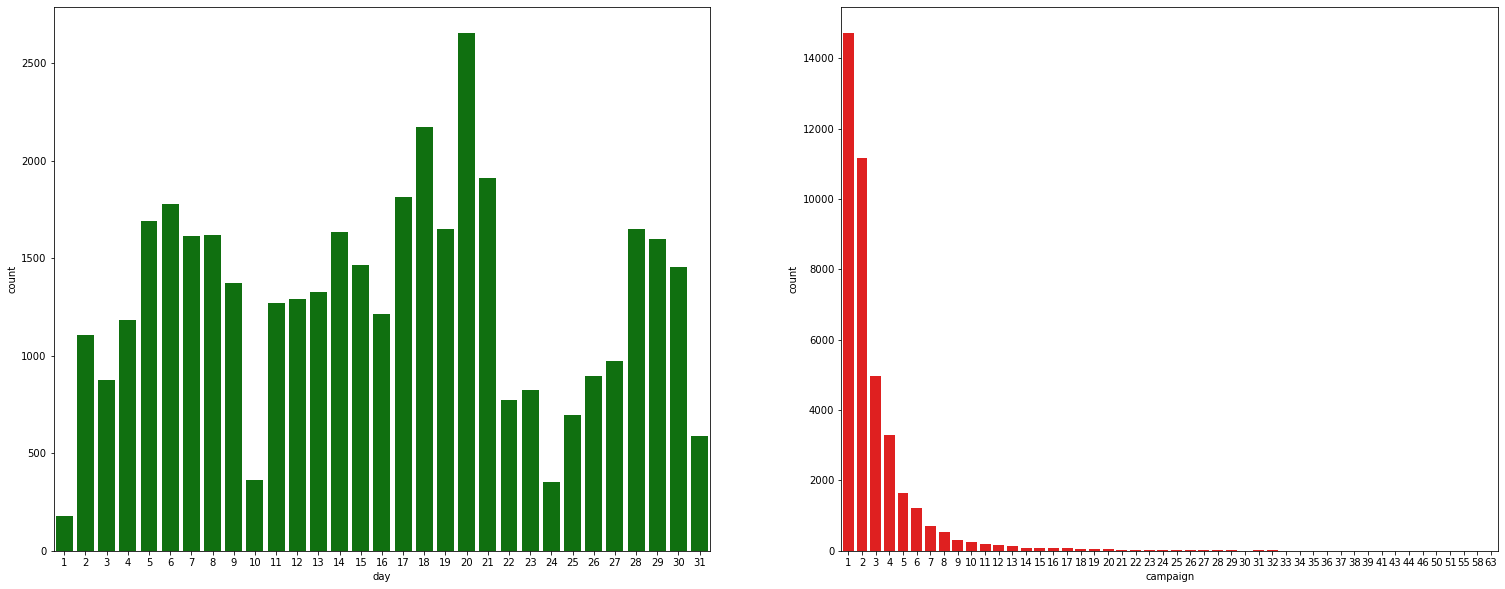

In [9]:
plt.figure(figsize=(40,10))

plt.subplot(1,3,1)
sns.countplot(df['day'], color = 'green')

plt.subplot(1,3,2)
sns.countplot(df['campaign'],  color = 'red')

1. Son grafikten müşterilerin 10. aranmalarından sonra aranma oranlarının düştüğü görülüyor.

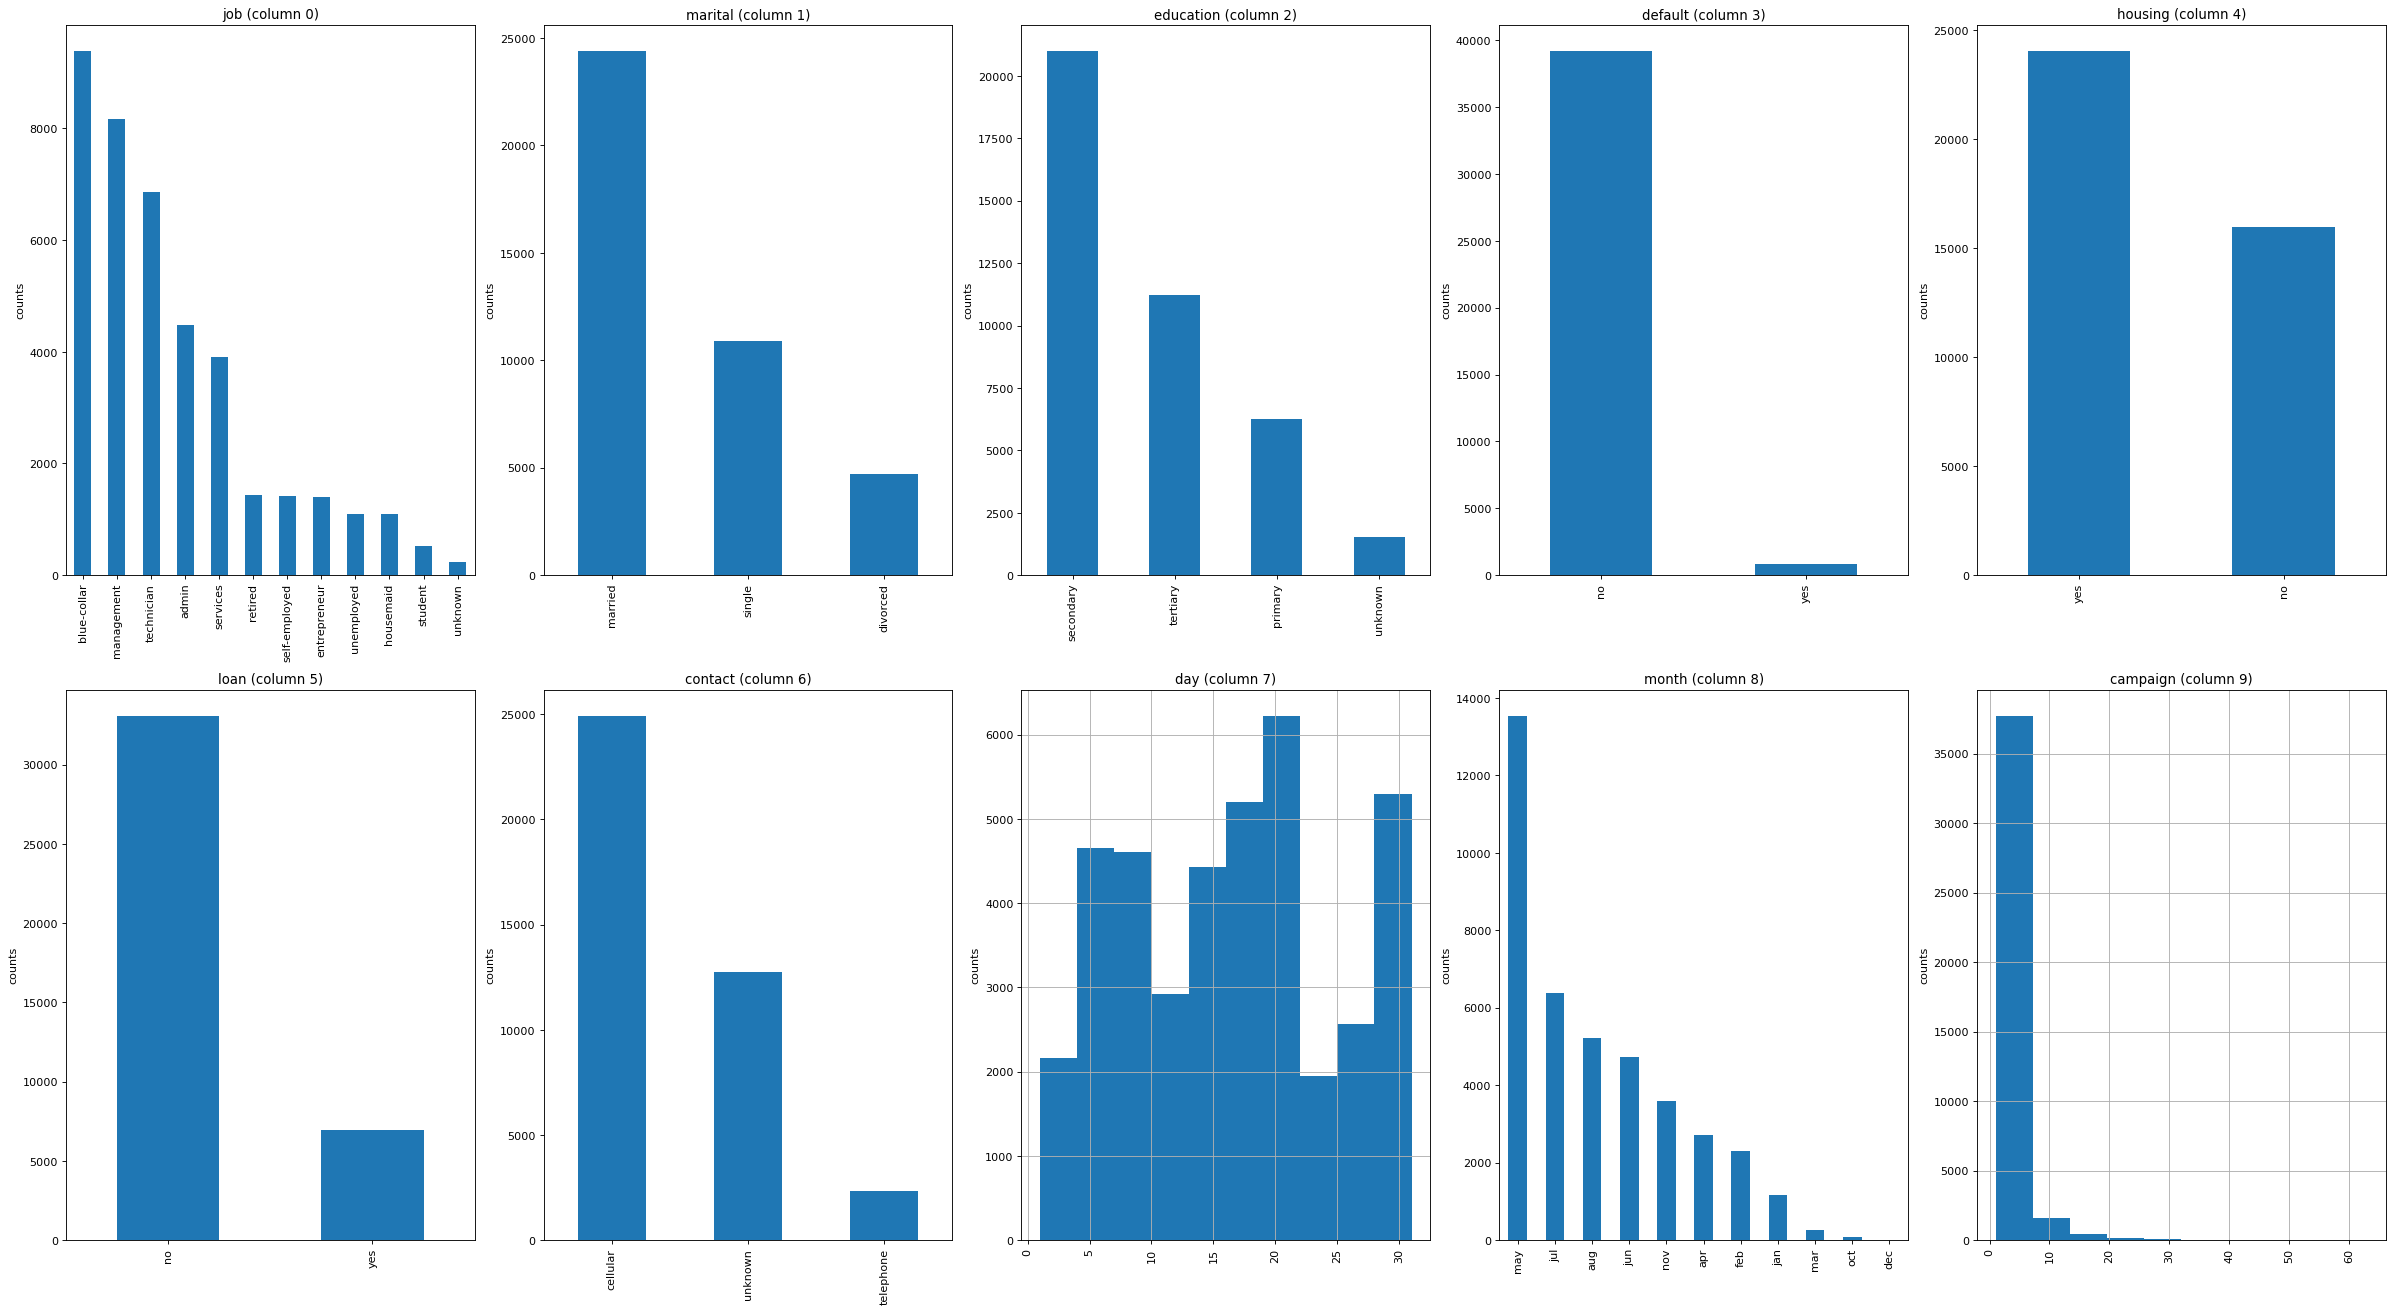

In [10]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
plotPerColumnDistribution(df, 10, 5)

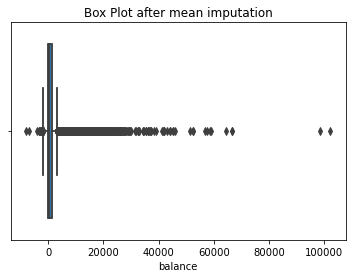

In [11]:
#Default kolonum için Mean outlier değerleri kontrol ediyorum
sns.boxplot(df['balance'])
plt.title("Box Plot before mean imputation")
q1 = df['balance'].quantile(0.25)
q3 = df['balance'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
m = np.mean(df['balance'])
for i in df['balance']:
    if i > Upper_tail or i < Lower_tail:
            df['balance'] = df['balance'].replace(i, m)
sns.boxplot(df['balance'])
plt.title("Box Plot after mean imputation")
plt.show()  

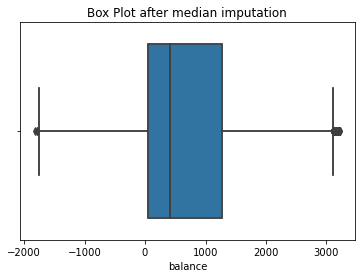

In [12]:
#Default kolonum için Median outlier değerleri kontrol ediyorum
sns.boxplot(df['balance'])
plt.title("Box Plot before median imputation")
q1 = df['balance'].quantile(0.25)
q3 = df['balance'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(df['balance'])
for i in df['balance']:
    if i > Upper_tail or i < Lower_tail:
            df['balance'] = df['balance'].replace(i, med)
sns.boxplot(df['balance'])
plt.title("Box Plot after median imputation")
plt.show()   

****Median outlierlar mean outlierlara göre daha güçlü bir sonuç ortaya koyuyor.

In [13]:
df.default.value_counts(normalize=True)

no     0.979775
yes    0.020225
Name: default, dtype: float64

****Default kolonumun %97 si no'dan oluşuyor varyansı çok düşük,modelimize bir katkısı olmayacaktır.Drop edilecek.

In [14]:
#Duplicate değer var mı kontrol edildi.
print(df[df.duplicated()])

Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, y]
Index: []


In [15]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,638.291648,16.017225,254.824300,2.882175
std,9.641776,751.788596,8.278127,259.366498,3.239051
min,19.000000,-1746.000000,1.000000,0.000000,1.000000
25%,33.000000,55.000000,8.000000,100.000000,1.000000
50%,39.000000,409.000000,17.000000,175.000000,2.000000
75%,48.000000,1274.277550,21.000000,313.000000,3.000000
max,95.000000,3103.000000,31.000000,4918.000000,63.000000


In [16]:
#datada missing values'lar var mı kontrol edildi.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        40000 non-null  int64  
 1   job        40000 non-null  object 
 2   marital    40000 non-null  object 
 3   education  40000 non-null  object 
 4   default    40000 non-null  object 
 5   balance    40000 non-null  float64
 6   housing    40000 non-null  object 
 7   loan       40000 non-null  object 
 8   contact    40000 non-null  object 
 9   day        40000 non-null  int64  
 10  month      40000 non-null  object 
 11  duration   40000 non-null  int64  
 12  campaign   40000 non-null  int64  
 13  y          40000 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 4.3+ MB


In [17]:
#Bazı kolonlardaki unknown değerler modelimize bir anlam sağlamayacağı için drop edildi.
df = df[df.job != 'unknown']
df = df[df.education != 'unknown']
df_copy = df.copy()

In [18]:
df.y.value_counts(normalize=True)

no     0.927174
yes    0.072826
Name: y, dtype: float64

Text(0.5, 1.0, 'Target Distributions \n (0: No || 1: Yes)')

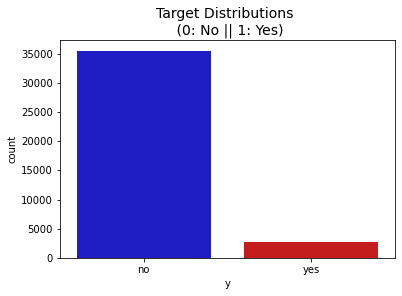

In [19]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('y', data=df, palette=colors)
plt.title('Target Distributions \n (0: No || 1: Yes)', fontsize=14)

Sadece % 7.2  kesim term deposit aramalarına evet demiş

Grafiklerden de gördüğümüz kadarıyla target kolonumuz imbalanced yani yüksek derecede dengesizlik var.Çoğu değerimiz 0 dan yani no değerinden oluşuyor.Bu gibi durumlarda bu dengesizliği göremezsek modelimiz yanlış çalışacaktır çünkü modelimiz bütün değerlere 0 derse zaten %92 lik bir başarı oranı yakalayacak ama confusion matrix'e bakıldığında 1 değerlerinin yani yes değerlerinin çoğunluğuna da 0 olarak tahminlediğini göreceğiz.Bu bakımdan model oluştururken bunu göz önüne alacağım ve train datama oversample veya undersample yapacağım. 

* Korelasyon matrisim

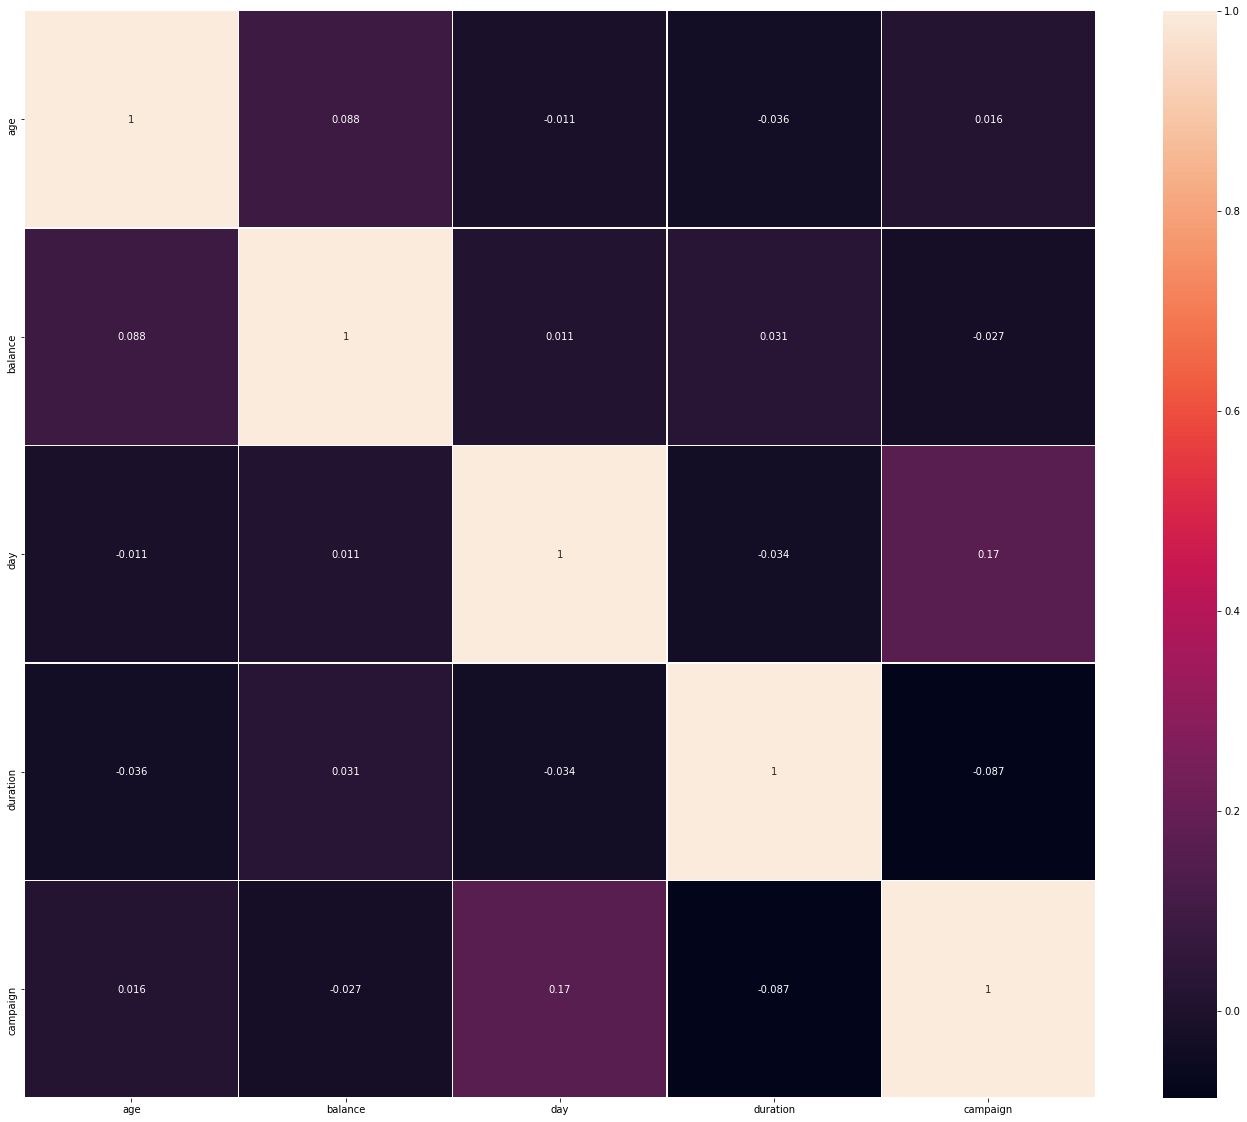

In [20]:
plt.subplots(figsize=(24,20))
sns.heatmap(df.corr(), annot=True, linewidths=.5);

**Korelasyon matrisimin sonucuna göre target değerimin gün ve yaşla kolonlarıyla daha alakalı olduğunu görüyorum.Bu kolonlardan yeni featureler çıkartmaya çalıacağım.
****Yine kolonlar arasında bir multicollinearity gözükmüyor.

# FEATURE ENGİNEERİNG

In [21]:
bins= [18,24,35,55,100]
labels = ['young_adult','adult','middle_adult','older_adult']
df['age_group'] = pd.cut(df['age'],bins=bins, labels=labels, right=False)

df['month'] = df['month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6
                               ,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}) 


df['year'] = 2020
df['tarih']=pd.to_datetime(df[['year','month','day']])
df['day_of_week'] = df['tarih'].dt.day_name()
df['weekend'] = np.where((df['day_of_week'] == 'Saturday') | (df['day_of_week'] == 'Sunday'),1,0)

#Ayın son 5 günü
df['end_month'] = np.where(df['day'] > 24,1,0)

#Ayın ilk 5 günü
df['begin_month'] = np.where(df['day'] < 6,1,0)

****Feature engineering kısmının ilk başında yapmak istediğim datamızda bulunan yaş kolonlarından yeni bir kategorik değişken oluşturmak oldu.Bunu yaparken düşüncem belli yaş gruplarının bankaların term deposit aramalarına nasıl cevap verecekleri olduSen.Modelimin sistemi anlamasında yardımcı olabilecek bir feature olarak düşündüm.Belirli yaş aralıkları oluşturup datama ekledim.

****Daha sonra bir haftasonu kolonu oluşturmak istedim.Çünkü haftasonları genelde insanların dinlenmeye ayırdıkları zamanlardır ve bu günlerde banka aramalarına çok hoş bakmayabilirler.Bu sebeple böyle bir feature olmasının modelime yardımcı olacağını düşündüm.

****En son olarak eklediğim 2 feature ayın başlangıç ve bitiş tarihleri idi.Buradaki düşüncem insanların ay sonlarında ve aybaşlarında en çok paraya ihtiyacı olan dönemlerdir çünkü fatura ödemeleri bu zamanlar olur.Genelde maaşlar ay başında alınır.İnsanların en çok parasının olduğu dönemler ve en çok yatırım yaptıkları zamanlar olarak düşünebiliriz.Bu sebeplerden dolayı ilk 5 gün ve son 5 gün olacak şekilde datamı böldüm.

In [22]:
df.drop(columns = ['default','year','tarih','day'], axis = 1,inplace=True) 

**** Datamı scale etmem lazım,kategorik değişkenlerin binary hallerine çevrilmesi lazım.

In [23]:
df.y.replace(('yes', 'no'), (1, 0), inplace=True)

In [24]:
categorical_columns = ['job','marital', 'education',  'housing','loan','contact','day_of_week','y','age_group']
feature_scale = [feature for feature in df.columns if feature not in categorical_columns]

scaler = StandardScaler()
scaler.fit(df[feature_scale])

scaled_data = pd.concat([df[categorical_columns].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(df[feature_scale]), columns=feature_scale)],
                    axis=1)

In [25]:
dummy_columns= ['job','marital', 'education', 'housing', 'loan','month', 'contact','day_of_week','age_group']
df = pd.get_dummies(scaled_data, columns = dummy_columns, drop_first=True)

****Daha önce varyansı çok düşük olan default kolonu ile günleri oluşturmak için kullandığım yıl ve tarih kolonumuda drop ediyorum

In [26]:
features = df.drop(columns = ['y']).columns
target = df.y

X = df[features].values
y = df.y

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE

In [28]:
print("Smotedan önce datadaki '1' sayısı: {}".format(sum(y_train == 1))) 
print("Smotedan önce datadaki '0' sayısı: {} \n".format(sum(y_train == 0))) 
                                                     
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority',random_state = 42)
X_train, y_train = sm.fit_sample(X_train, y_train)
  
print("Smotedan sonra datadaki '1' sayısı: {}".format(sum(y_train == 1))) 
print("Smotedan sonra datadaki '0' sayısı: {}".format(sum(y_train == 0))) 

Smotedan önce datadaki '1' sayısı: 2255
Smotedan önce datadaki '0' sayısı: 28415 

Smotedan sonra datadaki '1' sayısı: 28415
Smotedan sonra datadaki '0' sayısı: 28415


* ***** Datamızdaki eşit olmayan dağılım sorununu çözmek için kullandığım yöntem oversampling olacak bunu yaparken smote toolunu kullanacağım.Oversampling kısaca azınlık sınıfındaki örnekleri aşırı örneklemektir.Yeni örnekleri üretmek için en yaygın kullanılan yaklaşımlardan biri Sentetik Azınlık Aşırı Örnekleme Technique (SMOTE) olarak adlandırılır.Smote'un klasik random over sampling'ten farkı; random over sampling orijinal örneklerin tekrarlanmasıyla eğitim veri kümesinin boyutunu artırır,eğitim örneklerinin çeşitliliğinde herhangi bir artışa neden olmaz fakat smote yalnızca eğitim veri setinin boyutunu arttırmakla kalmaz, aynı zamanda çeşitliliği de artırır.Bu sayede daha güçlü bir train datası hazırlamış oluruz.

# MODELLEME 

In [29]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    LGBMClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis()]

log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Validation Results****')
    test_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, test_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    f1 = f1_score(y_test, test_predictions , average='weighted')
    print("f1 - score : {:.4%}".format(f1))

    pre = precision_score(y_test, test_predictions, average='weighted')
    print("precision - score : {:.4%}".format(pre))

    rec = recall_score(y_test, test_predictions, average='weighted' )
    print("recall - score : {:.4%}".format(rec) )

    test_probs = clf.predict_proba(X_test)
    ll = log_loss(y_test, test_probs)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
    
print("="*30)

KNeighborsClassifier
****Validation Results****
Accuracy: 87.9238%
f1 - score : 89.9525%
precision - score : 93.5589%
recall - score : 87.9238%
Log Loss: 1.7591199574571192
DecisionTreeClassifier
****Validation Results****
Accuracy: 91.3667%
f1 - score : 91.7462%
precision - score : 92.1947%
recall - score : 91.3667%
Log Loss: 2.9818296783295355
LogisticRegression
****Validation Results****
Accuracy: 87.6761%
f1 - score : 89.9474%
precision - score : 94.4048%
recall - score : 87.6761%
Log Loss: 0.3522164318320511
[18:36:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier
****Validation Results****
Accuracy: 93.6098%
f1 - score : 93.3834%
precision - score : 93.2037%
recall - score : 93.6098%
Log Loss: 0.14174661934417382
LGBMClassifier
****Validation Results****
Accuracy: 93.7272%
f

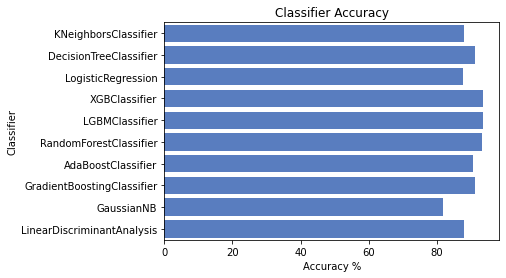

In [30]:
sns.set_color_codes("muted") 
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %') 
plt.title('Classifier Accuracy')
plt.show()

****Çeşitli classifierların train datasında değerlendirilmesi sonucunda accuracy metriğine göre en iyi modelin lgbm olduğu görüldü.

****Bundan sonraki kısımda gridsearch ile lgbm modelimi tuna edeceğim.

In [31]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
lgbm_model = LGBMClassifier()

param_grid = {'num_leaves':[2,5,9,15],  
              'learning_rate': [0.001,0.01,0.1], 
              'n_estimators': [100,150,300,500],
             'max_depth':[1,3,5,8]}  


grid = GridSearchCV(estimator = LGBMClassifier(),param_grid = param_grid,scoring = 'f1', cv = 10, verbose = 2, n_jobs=-1)
#grid.fit(X_train,y_train)
#print(grid.best_score_)
#print(grid.best_params_)

****Modelimi tune ederken kullandığım parametre f1 oldu.f1 bu datasette için önemli olan recall ve precisiondan oluşuyor.

****GridSearchcv sonucunda buldupum en uygun parametlere num_leaves=5,learning_rate=0.1,n_estimators=300,max_depth=1 şeklinde oldu.

In [32]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(num_leaves = 5,learning_rate = 0.1,n_estimators = 300,max_depth = 1)
model_lgb = lgbm.fit(X_train, y_train)
y_train_lgb = model_lgb.predict(X_train)
y_test_lgb = model_lgb.predict(X_test)

print(confusion_matrix(y_test,y_test_lgb))
print(classification_report(y_test,y_test_lgb, digits = 3))

print('Train-set accuracy: %0.3f' % accuracy_score(y_train, y_train_lgb))
print('Test-set accuracy: %0.3f' % accuracy_score(y_test, y_test_lgb))

[[6415  716]
 [ 110  427]]
              precision    recall  f1-score   support

           0      0.983     0.900     0.940      7131
           1      0.374     0.795     0.508       537

    accuracy                          0.892      7668
   macro avg      0.678     0.847     0.724      7668
weighted avg      0.940     0.892     0.909      7668

Train-set accuracy: 0.911
Test-set accuracy: 0.892


**Test datasının confusion matrisine baktığımda 101 false negative 427 true negative değere sahip olduğu gördüm.Bu da kullandığım ilk parametlere
göre ilerleme kaydettiğimi anlıyorum.

In [33]:
scores = cross_val_score(lgbm, X_test, y_test, cv=5)
scores

array([0.93872229, 0.93872229, 0.93285528, 0.93933464, 0.92889759])

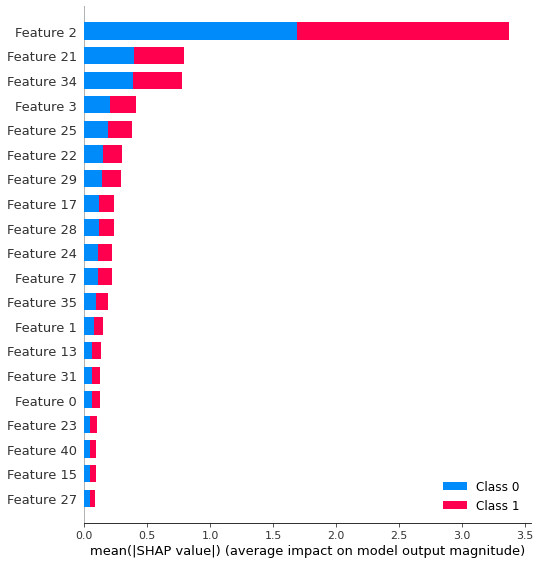

In [34]:
import shap
lgbm_mod = shap.TreeExplainer(model_lgb)
shap_lgbm = lgbm_mod.shap_values(X_train)

shap.summary_plot(shap_lgbm, X_train, plot_type="bar")

#  Determine the segments of customers our client should prioritize.

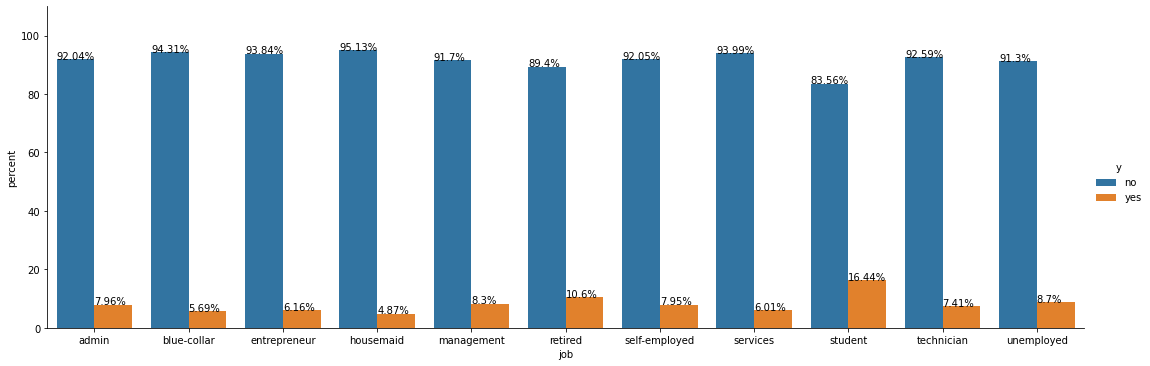

In [35]:
x,y = 'job', 'y'

df1 = df_copy.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1,height=5, aspect=3)
g.ax.set_ylim(0,110)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

****Bu kısımda hangi segmenteki müşterilere öncelik vermemiz gerektiğine bakacağız.
****İlk grafiğimde iş kollarından çıkarımlar yapmaya ve hangi iş kollarına öncelik vermemiz gerektiğinden bahsedeceğim.
****Grafikte en yüksek evet deme oranına sahip ilk 5 iş kolu ;

1. Student(yüzde 15.65 evet oranına sahip)
2. Retired(yüzde 10.51 evet oranına sahip)
3. Unemployed(yüzde 8.7 evet oranına sahip)
4. Management(yüzde 8.28 evet oranına sahip)
5. Self-employed(yüzde 7.92 evet oranına sahip)

Bu sırayla öncelik verilebilir.

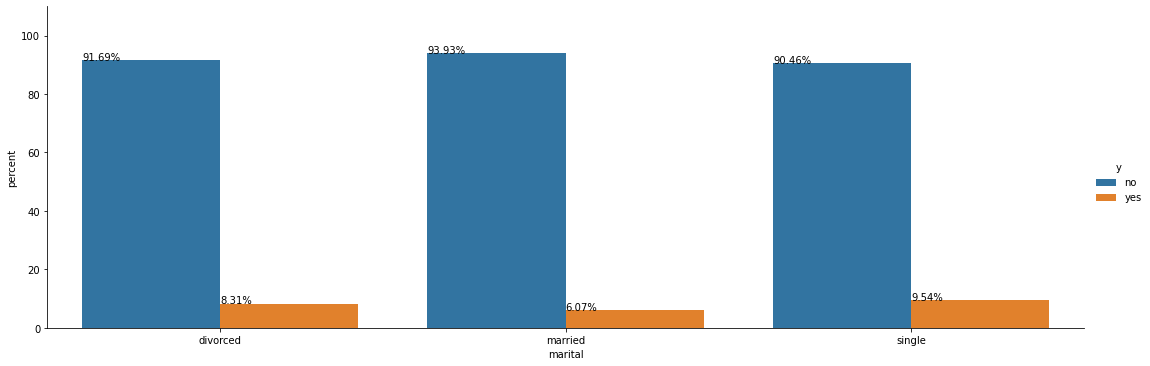

In [36]:
x,y = 'marital', 'y'

df1 = df_copy.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1,height=5, aspect=3)
g.ax.set_ylim(0,110)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

****Burada insanların medeni hallerine göre oluşturulan grafikte evet sıralaması şu şekilde;
1. Single (yüzde 9.43 evet oranına sahip)
2. Divorced (yüzde 8.28 evet oranına sahip)
3. Married (yüzde 6.06 evet oranına sahip)

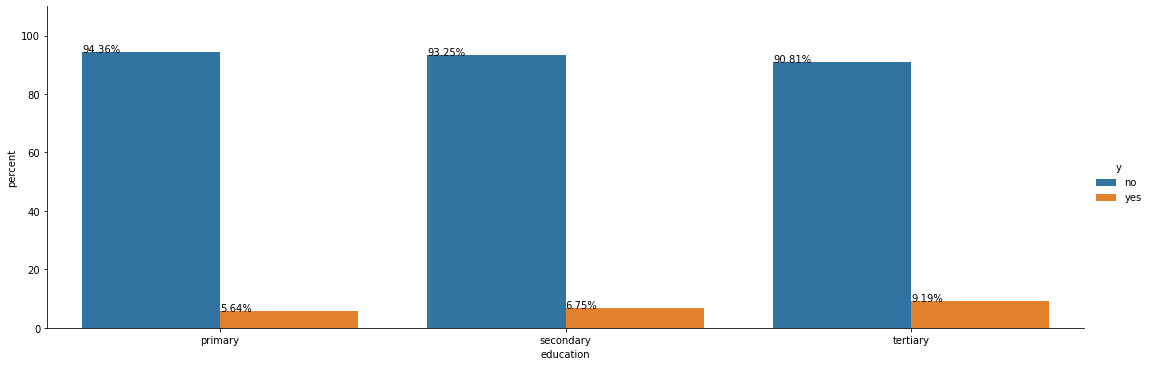

In [37]:
x,y = 'education', 'y'

df1 = df_copy.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1,height=5, aspect=3)
g.ax.set_ylim(0,110)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

****Burada insanların eğitim seviyelerine göre oluşturulan grafikte evet sıralaması şu şekilde;
1. Tertiary (yüzde 9.19 evet oranına sahip)
2. Secondary (yüzde 6.75  evet oranına sahip)
3. Primary(yüzde 5.64 evet oranına sahip) 


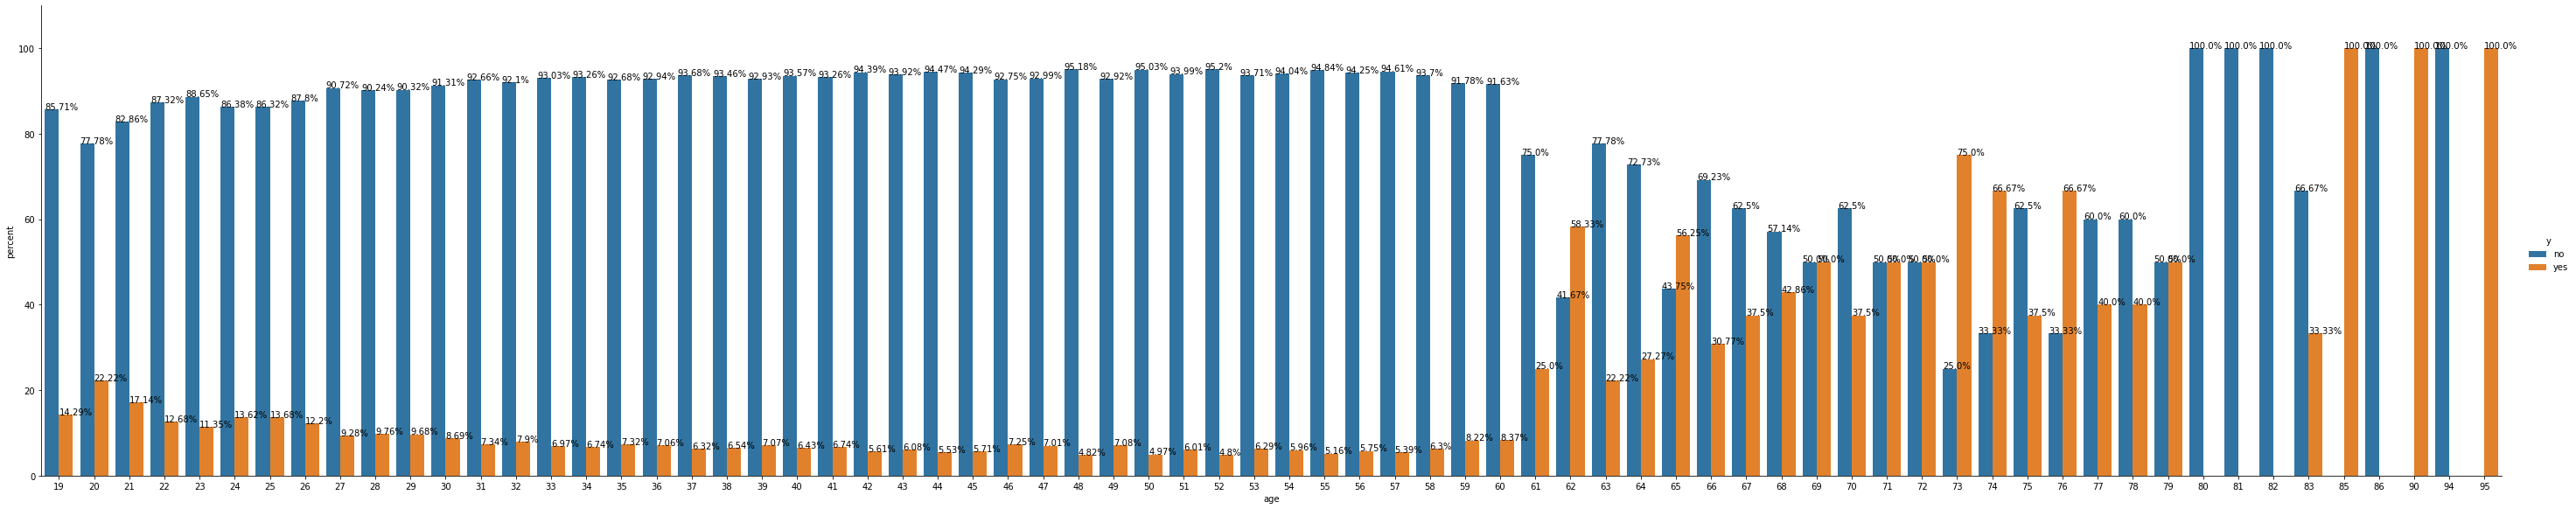

In [38]:
x,y = 'age', 'y'

df1 = df_copy.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1,height=8, aspect=5)
g.ax.set_ylim(0,110)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

****Yaş kolonuna baktığımızda öncelik vermemiz gereken yaş aralığı 60 ile 80 ve 93 ve 90 aralığında çıkıyor.

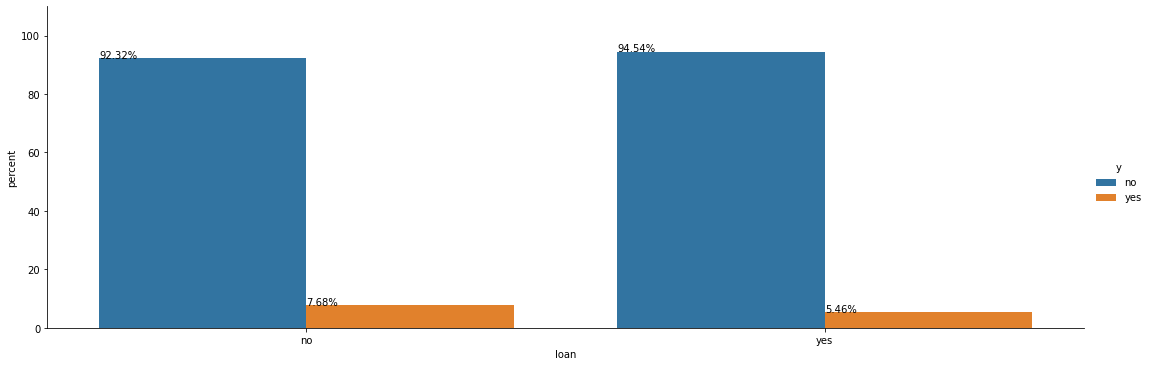

In [39]:
x,y = 'loan', 'y'

df1 = df_copy.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1,height=5, aspect=3)
g.ax.set_ylim(0,110)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

****Borcu olmayanların, olanlara kıyasla biraz daha fazla evet demeye meyilli olduklarını görüyoruz.
1. Borcu olmayanlar (yüzde 7.68 evet demiş)

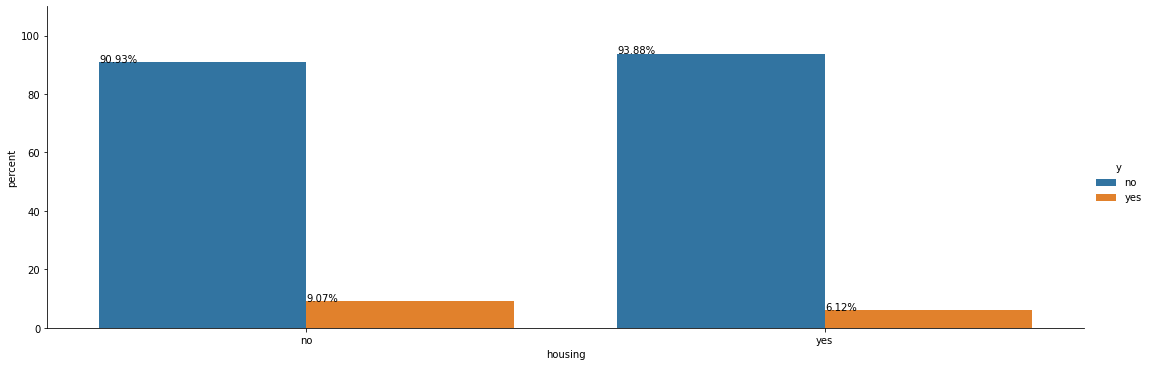

In [40]:
x,y = 'housing', 'y'

df1 = df_copy.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1,height=5, aspect=3)
g.ax.set_ylim(0,110)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

****Ev borcu olmayanların, olanlara kıyasla evet demeye daha yatkın olduklarını gözlemliyoruz.
1. Ev borcu olmayanlar (yüzde 9.07 evet demişler)

# What makes the customers buy?Tell us which feature we should be focusing more on.

****Müşteri bazında bu soruya cevap vermem gerekirse;
****İnsanların term deposit yapmasındaki en önemli sebep bulundurdukları parayı arttırmak.Bunu gerçekleştirmenin 3 yolu var.

1. Zaman
2. Faiz oranı
3. Para miktarı
****Paramızı bankada ne kadar fazla tutarsak o kadar artacaktır.

****Bankanın term deposit için verdiği faiz oranı ne kadar fazla ise o kadar fazla müşteri çekmeye başlayacaktır.Bankamızın bulunduğu klasmandaki diğer bankaların faiz oranlarına göre bir miktar daha yüksek faiz verilmesi veya ilk yatırılacak paranın 2 katı üzerinden faiz işlemesi gibi şeyler düşünülebilir.

****Daha fazla müşteri çekmek için fırsat günleri oluşturulabilir.Çeşitli kampanyalar ile daha fazla müşteri çekilebilir.

****Bankadaki ana para miktarımız ne kadar fazla olursa ona işlenen faizde bir o kadar fazla olacaktır.Bu durumda banka için önemli olabilecek başka bir özellik kişinin maaşı olabilir.Çünkü müşterimizin maaşı ne kadar fazla ise yatırım yapma olasılığı ve geri dönüş alma olasılığıda aynı şekilde artacaktır.

****Daha önceki yıllardan term deposit yapmış müşteriler belli aralıklarla kontrol edilebilir.Yeni faiz oranlarında bahsedilebilir.
****Yine daha önce bizimle çalışmış insanlara bankayı daha cazip kılmak amacı ile faiz düzenlemesi veya parayı istedikleri zaman hesaptan çekme sözü verilebilir.

****Müşterilere çeşitli yollardan ulaşabilecekleri uygulamalar geliştirmek yine çok iyi yöntemdir.Masaüstü,telefon uygulamaları oluşturmak ve bunları müşterilere sunmak müşteri memnuniyetini ve bağlılığını arttıracaktır.

****Hedef kitlemizi iyi belirlemek bize her zaman artı sağlayacaktır.Kitlemizi bilip onlara uygun kelimeler kullanmak satış kısmında bankanın yaranına olacaktır.Bir çiftçi ile bir yöneticinin hayata bakış açıları ve aldıkları eğitimler çok farklılık gösterir bunun için kişiye özel vaadler ve terimler kullanmak o müşteriyi bize kazandıracaktır.

****İnsanların meşgul olduğu saatlerde aramak(mesai saatleri) veya özel ve tatil günlerinde aramak yanlış bir uygulama olabilir.Çünkü insanlar bu günlerde bu alanlarla uğraşmak istemeyebilirler.

****REKLAM yapmak yine en önemli unsurlardan bir tanesi olacaktır.